In [1]:
import zipfile
import os
import shutil
import random

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 1. Ekstraksi dataset dari dataset6.zip
local_zip = './dataset6.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

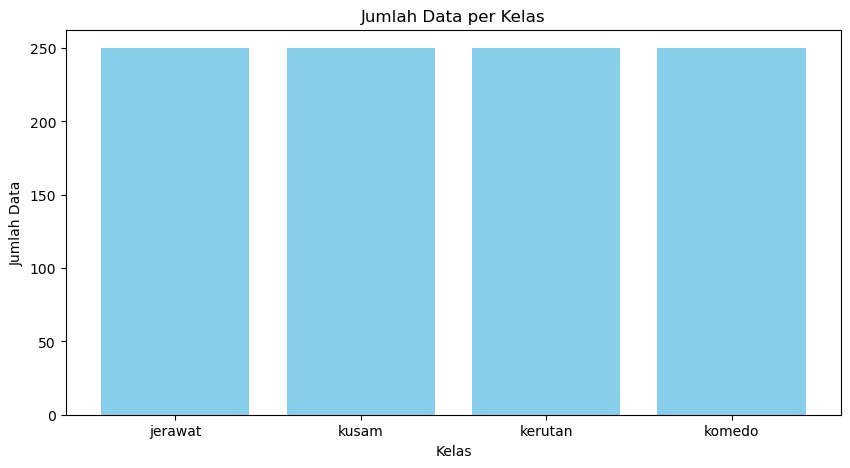

In [3]:
# 2. Visualisasi jumlah data tiap kelas
class_names = ['jerawat', 'kusam', 'kerutan', 'komedo']
data_count = []

for class_name in class_names:
    class_dir = f'./dataset6/{class_name}'
    data_count.append(len(os.listdir(class_dir)))

plt.figure(figsize=(10, 5))
plt.bar(class_names, data_count, color='skyblue')
plt.title('Jumlah Data per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.show()

In [4]:
# 3. Preprocessing: Resize dan Normalisasi, lalu simpan kembali di folder masing-masing
target_size = (224, 224)
preprocessed_dir = './preprocessed_dataset'

if not os.path.exists(preprocessed_dir):
    os.makedirs(preprocessed_dir)

for class_name in class_names:
    class_dir = f'./dataset6/{class_name}'
    processed_class_dir = os.path.join(preprocessed_dir, class_name)
    if not os.path.exists(processed_class_dir):
        os.makedirs(processed_class_dir)

    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalisasi

        # Simpan kembali gambar yang telah diproses
        img = tf.keras.preprocessing.image.array_to_img(img)
        img.save(os.path.join(processed_class_dir, img_file))

In [5]:
# 4. Augmentasi dan simpan dalam folder aug
augmentation_dir = './augmented_dataset'

if not os.path.exists(augmentation_dir):
    os.makedirs(augmentation_dir)

# Fungsi untuk augmentasi
def augment_image(image):
    # Contoh augmentasi, Anda dapat menyesuaikan parameter sesuai kebutuhan
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.random_contrast(image, lower=0.2, upper=2.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.rot90(image, k=random.randint(0, 3))
    return image

for class_name in class_names:
    class_dir = os.path.join(preprocessed_dir, class_name)
    aug_class_dir = os.path.join(augmentation_dir, class_name)
    if not os.path.exists(aug_class_dir):
        os.makedirs(aug_class_dir)

    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0

        augmented_images = [augment_image(img) for _ in range(4)]  # Menghasilkan 4 versi augmentasi per gambar

        # Simpan gambar-gambar yang telah diproses dan di-augmentasi
        for i, augmented_img in enumerate(augmented_images):
            augmented_img = tf.keras.preprocessing.image.array_to_img(augmented_img)
            augmented_img.save(os.path.join(aug_class_dir, f'{i}_{img_file}'))

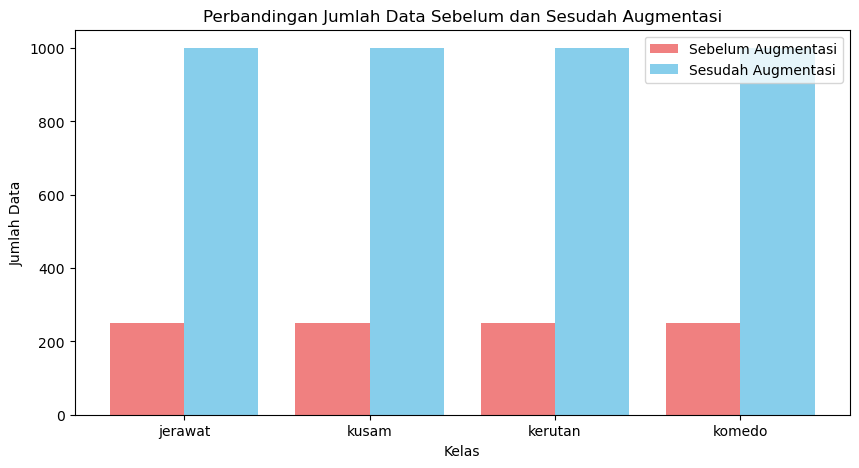

In [6]:
# 5. Visualisasi perbandingan jumlah dataset sebelum dan sesudah augmentasi
aug_data_count = [len(os.listdir(os.path.join(augmentation_dir, class_name))) for class_name in class_names]

plt.figure(figsize=(10, 5))
width = 0.4
x = np.arange(len(class_names))
plt.bar(x - width/2, data_count, width, label='Sebelum Augmentasi', color='lightcoral')
plt.bar(x + width/2, aug_data_count, width, label='Sesudah Augmentasi', color='skyblue')
plt.title('Perbandingan Jumlah Data Sebelum dan Sesudah Augmentasi')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.xticks(x, class_names)
plt.legend()
plt.show()

In [7]:
# 6. Membuat folder "train" dan "val" serta membagi data dengan rasio 80:20 dan memasukkannya ke setiap folder kelas
train_ratio = 0.8
train_dir = './train'
val_dir = './val'

if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

for class_name in class_names:
    augmented_class_dir = os.path.join(augmentation_dir, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)

    if not os.path.exists(train_class_dir):
        os.makedirs(train_class_dir)
    if not os.path.exists(val_class_dir):
        os.makedirs(val_class_dir)

    augmented_images = os.listdir(augmented_class_dir)
    random.shuffle(augmented_images)
    split_index = int(len(augmented_images) * train_ratio)
    train_images = augmented_images[:split_index]
    val_images = augmented_images[split_index:]

    # Copy data ke folder train
    for img_file in train_images:
        img_path = os.path.join(augmented_class_dir, img_file)
        shutil.copy(img_path, os.path.join(train_class_dir, img_file))

    # Copy data ke folder val
    for img_file in val_images:
        img_path = os.path.join(augmented_class_dir, img_file)
        shutil.copy(img_path, os.path.join(val_class_dir, img_file))

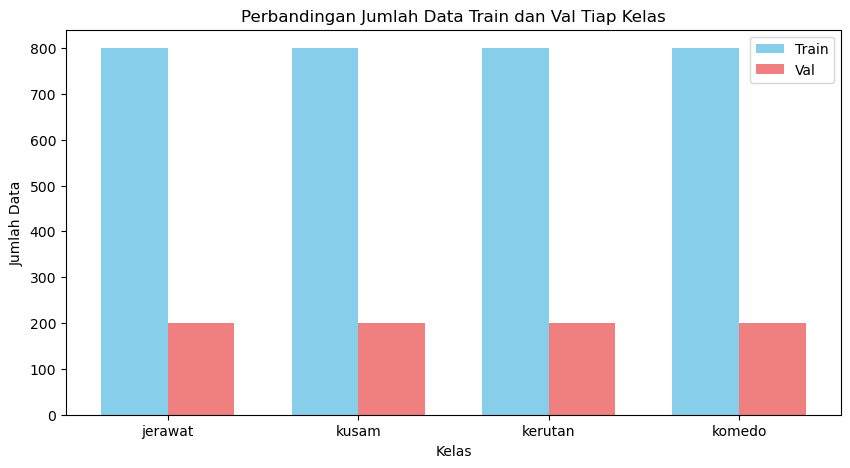

In [8]:
# 7. Visualisasi perbandingan jumlah data train dan val tiap class
train_data_count = [len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_names]
val_data_count = [len(os.listdir(os.path.join(val_dir, class_name))) for class_name in class_names]

plt.figure(figsize=(10, 5))
width = 0.35
x = np.arange(len(class_names))
plt.bar(x - width/2, train_data_count, width, label='Train', color='skyblue')
plt.bar(x + width/2, val_data_count, width, label='Val', color='lightcoral')
plt.title('Perbandingan Jumlah Data Train dan Val Tiap Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.xticks(x, class_names)
plt.legend()
plt.show()

# Model 1

In [29]:
# Mendefinisikan model MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Mendefinisikan model MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Mengatur layer base_model agar tidak dilatih (frozen)
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Menggunakan ImageDataGenerator tanpa augmentasi tambahan
train_datagen = ImageDataGenerator(rescale=1./255)  # Hanya normalisasi, tanpa augmentasi

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,  # Sesuaikan dengan ukuran batch yang Anda inginkan
    class_mode='categorical')

# Define the validation data generator (similar to the training data generator)
validation_datagen = ImageDataGenerator(rescale=1./255)  # Normalize the validation data

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,  # Adjust batch size as needed
    class_mode='categorical')

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [40]:
%%time
# Train the model with validation data
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_generator,  # Include validation data here
    validation_steps=len(validation_generator),  # Number of validation steps per epoch
    verbose=1)

Epoch 1/10
100/100 [==============================] - 104s 1s/step - loss: 0.0357 - accuracy: 0.9903 - val_loss: 0.1441 - val_accuracy: 0.9438
Epoch 2/10
100/100 [==============================] - 99s 992ms/step - loss: 0.0150 - accuracy: 0.9969 - val_loss: 0.1124 - val_accuracy: 0.9575
Epoch 3/10
100/100 [==============================] - 96s 959ms/step - loss: 0.0144 - accuracy: 0.9956 - val_loss: 0.1283 - val_accuracy: 0.9550
Epoch 4/10
100/100 [==============================] - 98s 982ms/step - loss: 0.0173 - accuracy: 0.9950 - val_loss: 0.1351 - val_accuracy: 0.9550
Epoch 5/10
100/100 [==============================] - 101s 1s/step - loss: 0.0097 - accuracy: 0.9972 - val_loss: 0.1348 - val_accuracy: 0.9488
Epoch 6/10
100/100 [==============================] - 99s 991ms/step - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.1155 - val_accuracy: 0.9600
Epoch 7/10
100/100 [==============================] - 97s 972ms/step - loss: 0.0051 - accuracy: 0.9991 - val_loss: 0.1746 - val_accura

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


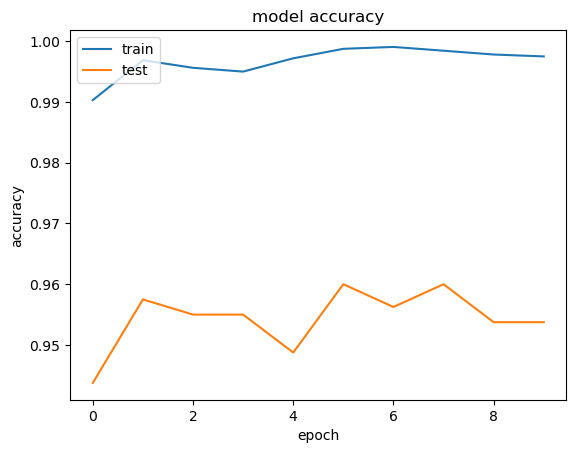

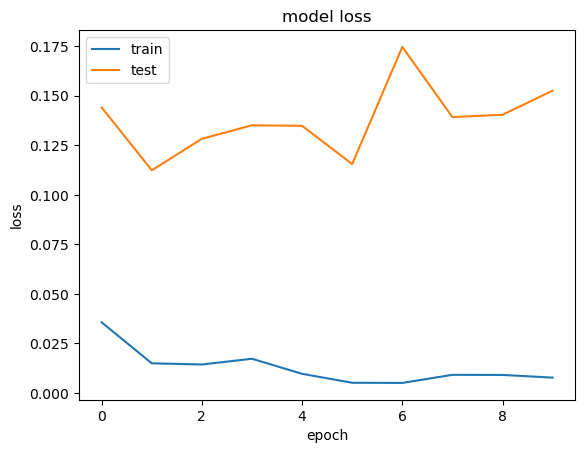

In [41]:
from matplotlib import pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
%%time
model.evaluate(validation_generator)

25/25 [==============================] - 17s 680ms/step - loss: 0.1525 - accuracy: 0.9538
CPU times: total: 1min 26s
Wall time: 17.3 s


[0.15252842009067535, 0.9537500143051147]

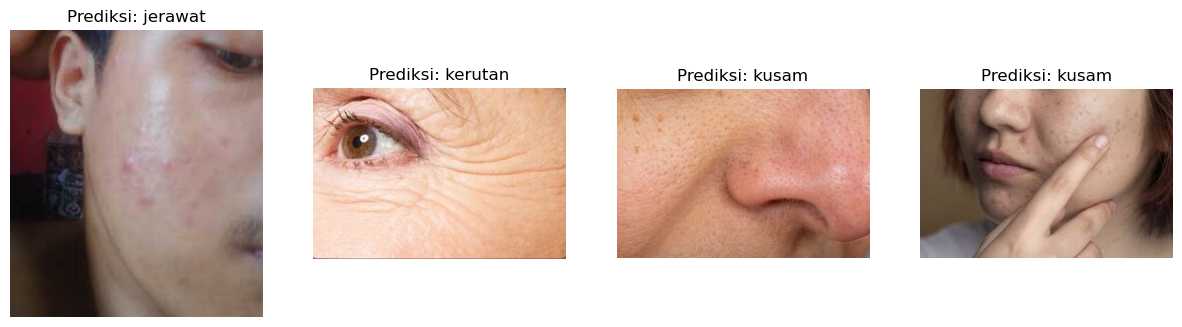

In [47]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path ke folder dengan citra-citra yang ingin diuji
folder_path = 'test/test/rendah'

# Membaca citra dari folder dan melakukan prediksi
predictions = []
image_names = []

for filename in os.listdir(folder_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Pastikan hanya file gambar yang dibaca
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Ubah mode warna ke RGB jika diperlukan
        image = cv2.resize(image, (224, 224))  # Sesuaikan ukuran gambar dengan ukuran input model

        # Normalisasi gambar
        image = image / 255.0  # Normalisasi sesuai dengan preprocessing yang dilakukan saat pelatihan

        # Lakukan prediksi
        prediction = model.predict(np.expand_dims(image, axis=0))[0]
        predicted_class = np.argmax(prediction)
        
        # Nama kelas berdasarkan indeks
        class_names = ['jerawat', 'kerutan', 'komedo', 'kusam']
        class_name = class_names[predicted_class]

        # Simpan hasil prediksi
        predictions.append(class_name)
        image_names.append(filename)

# Menampilkan hasil prediksi dalam bentuk citra dan teks
plt.figure(figsize=(15, 10))
for i in range(len(predictions)):
    plt.subplot(1, len(predictions), i + 1)
    plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(folder_path, image_names[i])), cv2.COLOR_BGR2RGB))
    plt.title(f'Prediksi: {predictions[i]}')
    plt.axis('off')

plt.show()

In [48]:
# Import library yang diperlukan
from tensorflow.keras.models import save_model

# Simpan model ke dalam file .h5
model.save('./HASIL/Skenario 7/skenario7.h5')


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load model yang telah Anda simpan
model = load_model('./HASIL/Skenario 2/skenario2.h5')  # Ganti 'nama_model.h5' dengan nama file model Anda

# Path ke folder dengan citra-citra yang ingin diuji
folder_path = 'test/test1'

# Membaca citra dari folder dan melakukan prediksi
predictions = []
image_names = []

for filename in os.listdir(folder_path):
    if filename.endswith(('.jpg')):  # Pastikan hanya file gambar yang dibaca
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Ubah mode warna ke RGB jika diperlukan
        image = cv2.resize(image, (224, 224))  # Sesuaikan ukuran gambar dengan ukuran input model

        # Normalisasi gambar
        image = image / 255.0  # Normalisasi sesuai dengan preprocessing yang dilakukan saat pelatihan

        # Lakukan prediksi
        prediction = model.predict(np.expand_dims(image, axis=0))[0]
        predicted_class = np.argmax(prediction)
        
        # Nama kelas berdasarkan indeks
        class_names = ['jerawat', 'kerutan', 'komedo', 'kusam']
        class_name = class_names[predicted_class]

        # Simpan hasil prediksi
        predictions.append(class_name)
        image_names.append(filename)

# Menampilkan hasil prediksi dalam bentuk citra dan teks
plt.figure(figsize=(15, 10))
for i in range(len(predictions)):
    plt.subplot(1, len(predictions), i + 1)
    plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(folder_path, image_names[i])), cv2.COLOR_BGR2RGB))
    plt.title(f'Prediksi: {predictions[i]}')
    plt.axis('off')

plt.show()


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'test/test1'

# Model 2

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Load MobileNetV2 pre-trained model
base_model2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the first 54 layers (up to the bottleneck block)
for layer in base_model2.layers[:54]:
    layer.trainable = False

# Add custom head on top of MobileNetV2
x = base_model2.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
num_classes = 4  # Ganti dengan jumlah kelas dalam dataset Anda
predictions = Dense(num_classes, activation='softmax')(x)

# Create a new model
model2 = Model(inputs=base_model2.input, outputs=predictions)

# Compile the model
model2.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
%%time
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Menggunakan ImageDataGenerator tanpa augmentasi tambahan
train_datagen = ImageDataGenerator(rescale=1./255)  # Hanya normalisasi, tanpa augmentasi

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,  # Sesuaikan dengan ukuran batch yang Anda inginkan
    class_mode='categorical')

# Define the validation data generator (similar to the training data generator)
validation_datagen = ImageDataGenerator(rescale=1./255)  # Normalize the validation data

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,  # Adjust batch size as needed
    class_mode='categorical')

# Train the model with validation data
history2 = model2.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_generator,  # Include validation data here
    validation_steps=len(validation_generator),  # Number of validation steps per epoch
    verbose=1)

In [ ]:
from matplotlib import pyplot as plt

# list all data in history
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
%%time
model2.evaluate(validation_generator)

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path ke folder dengan citra-citra yang ingin diuji
folder_path = 'test/test/rendah'

# Membaca citra dari folder dan melakukan prediksi
predictions = []
image_names = []

for filename in os.listdir(folder_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Pastikan hanya file gambar yang dibaca
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Ubah mode warna ke RGB jika diperlukan
        image = cv2.resize(image, (224, 224))  # Sesuaikan ukuran gambar dengan ukuran input model

        # Normalisasi gambar
        image = image / 255.0  # Normalisasi sesuai dengan preprocessing yang dilakukan saat pelatihan

        # Lakukan prediksi
        prediction = model2.predict(np.expand_dims(image, axis=0))[0]
        predicted_class = np.argmax(prediction)
        
        # Nama kelas berdasarkan indeks
        class_names = ['jerawat', 'kerutan', 'komedo', 'kusam']
        class_name = class_names[predicted_class]

        # Simpan hasil prediksi
        predictions.append(class_name)
        image_names.append(filename)

# Menampilkan hasil prediksi dalam bentuk citra dan teks
plt.figure(figsize=(15, 10))
for i in range(len(predictions)):
    plt.subplot(1, len(predictions), i + 1)
    plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(folder_path, image_names[i])), cv2.COLOR_BGR2RGB))
    plt.title(f'Prediksi: {predictions[i]}')
    plt.axis('off')

plt.show()

In [ ]:
import tkinter as tk
from tkinter import filedialog
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Inisialisasi jendela tkinter (GUI)
root = tk.Tk()
root.withdraw()  # Sembunyikan jendela utama

# Meminta pengguna untuk memilih file gambar
file_path = filedialog.askopenfilename(title="Pilih Gambar", filetypes=[("Image Files", "*.jpg *.jpeg *.png")])

# Cek apakah pengguna memilih file
if file_path:
    # Membaca gambar yang dipilih
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # Normalisasi gambar
    image = image / 255.0

    # Lakukan prediksi
    prediction = model2.predict(np.expand_dims(image, axis=0))[0]
    predicted_class = np.argmax(prediction)

    # Nama kelas berdasarkan indeks
    class_names = ['jerawat', 'kerutan', 'komedo', 'kusam']
    class_name = class_names[predicted_class]

    # Menampilkan hasil prediksi dalam bentuk citra dan teks
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB))
    plt.title(f'Prediksi: {class_name}')
    plt.axis('off')
    plt.show()
else:
    print("Anda belum memilih gambar.")

# Tutup jendela tkinter
root.destroy()
